In [1]:
onColab = True
model_path = './gru_conv'

# Decide batch size and validation split
batch_size = 16
validation_split = 0.2
test_split = 0.01
epochs = 200

dataset_path = './Training_smooth4.csv'

window = 600
stride = 20
# 864 / 8
telescope = 108

## Init
Initialize codalab, libraries and seed

In [2]:
#@title connect to codalab
if onColab:
  from google.colab import drive
  drive.mount('/gdrive')
  %cd /gdrive/MyDrive/University/ANN/CHALLENGE2

Mounted at /gdrive
/gdrive/MyDrive/University/ANN/CHALLENGE2


In [3]:
#@title Import libraries
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import sklearn
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

tf.config.list_physical_devices('GPU')

2.7.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
#@title init seed everywhere
seed = 21

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

## Dataset import and manipulation

In [5]:
dataset  = pd.read_csv(dataset_path)
print(dataset.shape)
dataset.describe()

(68480, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
count,68480.000000,68480.000000,68480.000000,68480.000000,68480.000000,68480.000000,68480.000000
mean,6.092922,4.695035,13.338334,2.448573,2.406234,23.226086,8.233436
std,1.850387,3.276479,11.401147,2.913908,0.977237,14.266795,11.008706
min,0.374103,-7.077979,-38.473173,-9.010790,-1.112831,-5.958147,-42.243388
25%,4.904693,2.311657,10.712777,0.460031,2.141229,12.587259,6.347854
50%,5.716228,4.707117,15.649231,2.623899,2.617772,20.122416,10.980749
75%,6.983162,7.004541,20.342571,4.607277,2.981481,31.174366,15.217164
max,15.390678,17.664854,38.463575,13.890761,4.938010,76.363121,28.687462


In [6]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
# inspect_dataframe(dataset, dataset.columns)

In [7]:
def normalize(dataset, t=None):
  if t is None or t == 'minmax':
    x_min = dataset.min(axis=0)
    print(x_min.shape)
    x_max = dataset.max()
    nd = (dataset - x_min) / (x_max - x_min)
    return nd
  elif t == 'mean_std':
    x_mean = dataset.mean()
    x_std = dataset.std()
    nd = (dataset - x_mean) / x_std
    return nd

In [8]:
normalized_ds = normalize(dataset)
normalized_ds.describe()

(7,)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
count,68480.000000,68480.000000,68480.000000,68480.000000,68480.000000,68480.000000,68480.000000
mean,0.380834,0.475815,0.673430,0.500375,0.581583,0.354516,0.711634
std,0.123223,0.132421,0.148189,0.127236,0.161504,0.173306,0.155203
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.301706,0.379489,0.639304,0.413545,0.537786,0.225281,0.685051
50%,0.355749,0.476303,0.703466,0.508031,0.616543,0.316814,0.750367
75%,0.440118,0.569156,0.764469,0.594635,0.676652,0.451068,0.810093
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
def chunk(dataset, window, telescope, stride):
  """
  divide the dataset in chunks. 
  It keeps the right-most elements and discard the left ones, if size and stride are not compatible with dimensions. 
  """
  size = window + telescope
  X = []
  Y = []
  for i in range(len(dataset) - size, -1, -stride):
    X.append(dataset[i: i + window])
    Y.append(dataset[i + window: i + size])
  X.reverse()
  Y.reverse()
  return (np.array(X), np.array(Y))

In [10]:
x, y = chunk(normalized_ds, window, telescope, stride)

In [11]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        # axs[i].set_ylim(0,1)
    plt.show()

In [12]:
# shuffle data so that 
x, y = sklearn.utils.shuffle(x, y, random_state=seed)
x.shape, y.shape

((3389, 600, 7), (3389, 108, 7))

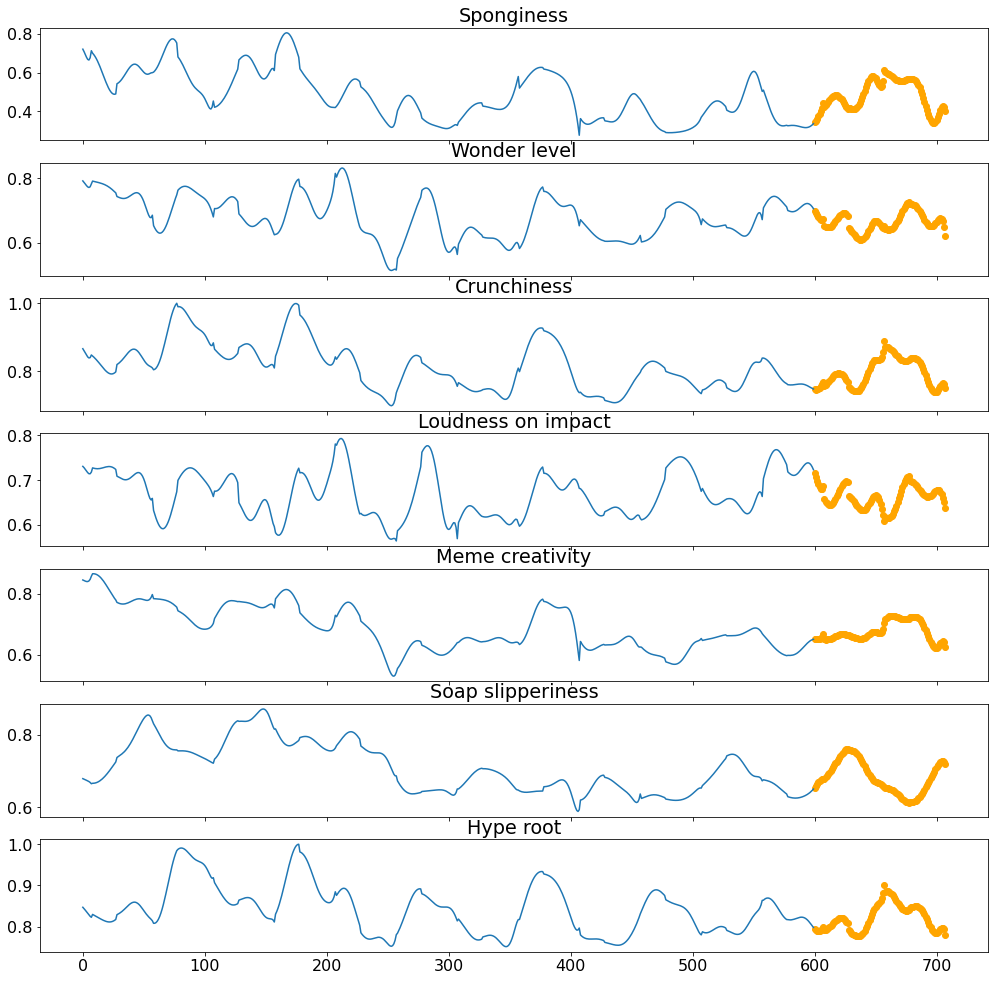

In [13]:
inspect_multivariate(x, y, dataset.columns, telescope)

## Model
build the model and learn

In [14]:
input_shape = (window, 7)
output_shape = (telescope, 7)

In [15]:
def build_model(input_shape, output_shape):
    # Build the neural network layer by layer
    # E1D1
    n_features = input_shape[1]
    n_past = input_shape[0]
    n_future = output_shape[0]

    #
    encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))        
    conv = tfkl.Conv1D(512, 3, padding='same', activation='relu')

    encoder_l1 = tf.keras.layers.GRU(200, return_state=True)
    encoder_outputs1 = encoder_l1(conv(encoder_inputs))

    encoder_states1 = encoder_outputs1[1:]

    #
    decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

    #
    decoder_l1 = tf.keras.layers.GRU(200, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
    decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

    #
    model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

    model_e1d1.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    return model_e1d1

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 600, 7)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 600, 512)     11264       ['input_1[0][0]']                
                                                                                                  
 gru (GRU)                      [(None, 200),        428400      ['conv1d[0][0]']                 
                                 (None, 200)]                                                     
                                                                                                  
 repeat_vector (RepeatVector)   (None, 108, 200)     0           ['gru[0][0]']                

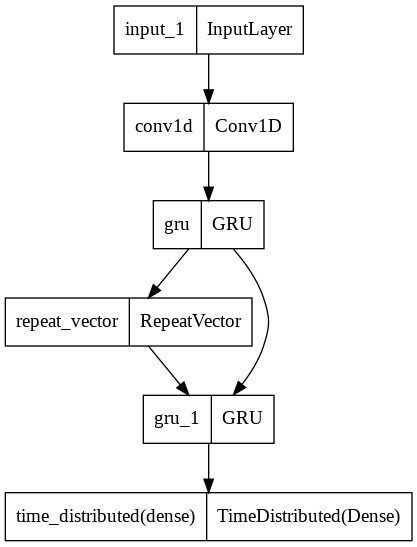

In [16]:
model = build_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [17]:
# Train the model
history = model.fit(
    x = x,
    y = y,
    batch_size = batch_size,
    epochs = epochs,
    validation_split = validation_split,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5),
        tfk.callbacks.ModelCheckpoint(model_path + '_ckpt', save_best_only=True)
    ]
).history

Epoch 1/200
170/170 [==============================] - ETA: 0s - loss: 0.0174 - mae: 0.0905

170/170 [==============================] - 50s 221ms/step - loss: 0.0174 - mae: 0.0905 - val_loss: 0.0115 - val_mae: 0.0738 - lr: 0.0010
Epoch 2/200
170/170 [==============================] - ETA: 0s - loss: 0.0111 - mae: 0.0746

170/170 [==============================] - 37s 215ms/step - loss: 0.0111 - mae: 0.0746 - val_loss: 0.0110 - val_mae: 0.0755 - lr: 0.0010
Epoch 3/200
170/170 [==============================] - 27s 161ms/step - loss: 0.0105 - mae: 0.0723 - val_loss: 0.0111 - val_mae: 0.0769 - lr: 0.0010
Epoch 4/200
170/170 [==============================] - ETA: 0s - loss: 0.0101 - mae: 0.0709

170/170 [==============================] - 36s 215ms/step - loss: 0.0101 - mae: 0.0709 - val_loss: 0.0102 - val_mae: 0.0713 - lr: 0.0010
Epoch 5/200
170/170 [==============================] - ETA: 0s - loss: 0.0096 - mae: 0.0691

170/170 [==============================] - 37s 215ms/step - loss: 0.0096 - mae: 0.0691 - val_loss: 0.0097 - val_mae: 0.0709 - lr: 0.0010
Epoch 6/200
170/170 [==============================] - ETA: 0s - loss: 0.0091 - mae: 0.0679

170/170 [==============================] - 37s 215ms/step - loss: 0.0091 - mae: 0.0679 - val_loss: 0.0088 - val_mae: 0.0656 - lr: 0.0010
Epoch 7/200
170/170 [==============================] - ETA: 0s - loss: 0.0081 - mae: 0.0643

170/170 [==============================] - 37s 216ms/step - loss: 0.0081 - mae: 0.0643 - val_loss: 0.0079 - val_mae: 0.0638 - lr: 0.0010
Epoch 8/200
170/170 [==============================] - ETA: 0s - loss: 0.0071 - mae: 0.0603

170/170 [==============================] - 37s 215ms/step - loss: 0.0071 - mae: 0.0603 - val_loss: 0.0070 - val_mae: 0.0601 - lr: 0.0010
Epoch 9/200
170/170 [==============================] - 28s 163ms/step - loss: 0.0068 - mae: 0.0592 - val_loss: 0.0071 - val_mae: 0.0617 - lr: 0.0010
Epoch 10/200
170/170 [==============================] - ETA: 0s - loss: 0.0061 - mae: 0.0562

170/170 [==============================] - 37s 215ms/step - loss: 0.0061 - mae: 0.0562 - val_loss: 0.0069 - val_mae: 0.0605 - lr: 0.0010
Epoch 11/200
170/170 [==============================] - ETA: 0s - loss: 0.0059 - mae: 0.0551

170/170 [==============================] - 36s 215ms/step - loss: 0.0059 - mae: 0.0551 - val_loss: 0.0066 - val_mae: 0.0591 - lr: 0.0010
Epoch 12/200
170/170 [==============================] - ETA: 0s - loss: 0.0059 - mae: 0.0552

170/170 [==============================] - 36s 215ms/step - loss: 0.0059 - mae: 0.0552 - val_loss: 0.0058 - val_mae: 0.0542 - lr: 0.0010
Epoch 13/200
170/170 [==============================] - 28s 162ms/step - loss: 0.0056 - mae: 0.0534 - val_loss: 0.0067 - val_mae: 0.0579 - lr: 0.0010
Epoch 14/200
170/170 [==============================] - 27s 161ms/step - loss: 0.0055 - mae: 0.0532 - val_loss: 0.0066 - val_mae: 0.0572 - lr: 0.0010
Epoch 15/200
170/170 [==============================] - ETA: 0s - loss: 0.0056 - mae: 0.0529

170/170 [==============================] - 36s 215ms/step - loss: 0.0056 - mae: 0.0529 - val_loss: 0.0058 - val_mae: 0.0538 - lr: 0.0010
Epoch 16/200
170/170 [==============================] - ETA: 0s - loss: 0.0054 - mae: 0.0522

170/170 [==============================] - 37s 217ms/step - loss: 0.0054 - mae: 0.0522 - val_loss: 0.0056 - val_mae: 0.0523 - lr: 0.0010
Epoch 17/200
170/170 [==============================] - 27s 161ms/step - loss: 0.0054 - mae: 0.0522 - val_loss: 0.0058 - val_mae: 0.0529 - lr: 0.0010
Epoch 18/200
170/170 [==============================] - ETA: 0s - loss: 0.0053 - mae: 0.0517

170/170 [==============================] - 37s 215ms/step - loss: 0.0053 - mae: 0.0517 - val_loss: 0.0055 - val_mae: 0.0523 - lr: 0.0010
Epoch 19/200
170/170 [==============================] - 28s 162ms/step - loss: 0.0051 - mae: 0.0508 - val_loss: 0.0057 - val_mae: 0.0530 - lr: 0.0010
Epoch 20/200
170/170 [==============================] - ETA: 0s - loss: 0.0051 - mae: 0.0506

170/170 [==============================] - 36s 213ms/step - loss: 0.0051 - mae: 0.0506 - val_loss: 0.0054 - val_mae: 0.0515 - lr: 0.0010
Epoch 21/200
170/170 [==============================] - 28s 162ms/step - loss: 0.0052 - mae: 0.0512 - val_loss: 0.0057 - val_mae: 0.0517 - lr: 0.0010
Epoch 22/200
170/170 [==============================] - 27s 161ms/step - loss: 0.0051 - mae: 0.0506 - val_loss: 0.0058 - val_mae: 0.0536 - lr: 0.0010
Epoch 23/200
170/170 [==============================] - 27s 162ms/step - loss: 0.0050 - mae: 0.0501 - val_loss: 0.0056 - val_mae: 0.0530 - lr: 0.0010
Epoch 24/200
170/170 [==============================] - ETA: 0s - loss: 0.0046 - mae: 0.0471

170/170 [==============================] - 37s 216ms/step - loss: 0.0046 - mae: 0.0471 - val_loss: 0.0051 - val_mae: 0.0490 - lr: 5.0000e-04
Epoch 25/200
170/170 [==============================] - 28s 162ms/step - loss: 0.0044 - mae: 0.0464 - val_loss: 0.0051 - val_mae: 0.0502 - lr: 5.0000e-04
Epoch 26/200
170/170 [==============================] - ETA: 0s - loss: 0.0044 - mae: 0.0464

170/170 [==============================] - 36s 211ms/step - loss: 0.0044 - mae: 0.0464 - val_loss: 0.0049 - val_mae: 0.0479 - lr: 5.0000e-04
Epoch 27/200
170/170 [==============================] - 28s 162ms/step - loss: 0.0044 - mae: 0.0461 - val_loss: 0.0050 - val_mae: 0.0479 - lr: 5.0000e-04
Epoch 28/200
170/170 [==============================] - ETA: 0s - loss: 0.0043 - mae: 0.0458

170/170 [==============================] - 37s 216ms/step - loss: 0.0043 - mae: 0.0458 - val_loss: 0.0048 - val_mae: 0.0472 - lr: 5.0000e-04
Epoch 29/200
170/170 [==============================] - 28s 164ms/step - loss: 0.0044 - mae: 0.0461 - val_loss: 0.0052 - val_mae: 0.0491 - lr: 5.0000e-04
Epoch 30/200
170/170 [==============================] - 27s 161ms/step - loss: 0.0043 - mae: 0.0459 - val_loss: 0.0049 - val_mae: 0.0485 - lr: 5.0000e-04
Epoch 31/200
170/170 [==============================] - 27s 161ms/step - loss: 0.0043 - mae: 0.0455 - val_loss: 0.0050 - val_mae: 0.0484 - lr: 5.0000e-04
Epoch 32/200
170/170 [==============================] - ETA: 0s - loss: 0.0040 - mae: 0.0437

170/170 [==============================] - 36s 212ms/step - loss: 0.0040 - mae: 0.0437 - val_loss: 0.0046 - val_mae: 0.0460 - lr: 2.5000e-04
Epoch 33/200
170/170 [==============================] - ETA: 0s - loss: 0.0040 - mae: 0.0433

170/170 [==============================] - 37s 217ms/step - loss: 0.0040 - mae: 0.0433 - val_loss: 0.0046 - val_mae: 0.0463 - lr: 2.5000e-04
Epoch 34/200
170/170 [==============================] - ETA: 0s - loss: 0.0040 - mae: 0.0433

170/170 [==============================] - 36s 212ms/step - loss: 0.0040 - mae: 0.0433 - val_loss: 0.0045 - val_mae: 0.0453 - lr: 2.5000e-04
Epoch 35/200
170/170 [==============================] - 28s 162ms/step - loss: 0.0040 - mae: 0.0432 - val_loss: 0.0045 - val_mae: 0.0457 - lr: 2.5000e-04
Epoch 36/200
170/170 [==============================] - ETA: 0s - loss: 0.0039 - mae: 0.0430

170/170 [==============================] - 37s 216ms/step - loss: 0.0039 - mae: 0.0430 - val_loss: 0.0045 - val_mae: 0.0457 - lr: 2.5000e-04
Epoch 37/200
170/170 [==============================] - 28s 162ms/step - loss: 0.0039 - mae: 0.0429 - val_loss: 0.0046 - val_mae: 0.0463 - lr: 2.5000e-04
Epoch 38/200
170/170 [==============================] - ETA: 0s - loss: 0.0039 - mae: 0.0428

170/170 [==============================] - 36s 212ms/step - loss: 0.0039 - mae: 0.0428 - val_loss: 0.0044 - val_mae: 0.0446 - lr: 2.5000e-04
Epoch 39/200
170/170 [==============================] - 28s 163ms/step - loss: 0.0039 - mae: 0.0427 - val_loss: 0.0044 - val_mae: 0.0449 - lr: 2.5000e-04
Epoch 40/200
170/170 [==============================] - 27s 162ms/step - loss: 0.0039 - mae: 0.0427 - val_loss: 0.0045 - val_mae: 0.0452 - lr: 2.5000e-04
Epoch 41/200
170/170 [==============================] - 27s 161ms/step - loss: 0.0039 - mae: 0.0426 - val_loss: 0.0045 - val_mae: 0.0451 - lr: 2.5000e-04
Epoch 42/200
170/170 [==============================] - 27s 161ms/step - loss: 0.0038 - mae: 0.0425 - val_loss: 0.0046 - val_mae: 0.0459 - lr: 2.5000e-04
Epoch 43/200
170/170 [==============================] - 27s 161ms/step - loss: 0.0038 - mae: 0.0422 - val_loss: 0.0045 - val_mae: 0.0451 - lr: 2.5000e-04
Epoch 44/200
170/170 [==============================] - ETA: 0s - loss: 0.0036 - mae: 0.0

170/170 [==============================] - 37s 217ms/step - loss: 0.0036 - mae: 0.0411 - val_loss: 0.0042 - val_mae: 0.0436 - lr: 1.2500e-04
Epoch 45/200
170/170 [==============================] - ETA: 0s - loss: 0.0036 - mae: 0.0410

170/170 [==============================] - 36s 214ms/step - loss: 0.0036 - mae: 0.0410 - val_loss: 0.0042 - val_mae: 0.0437 - lr: 1.2500e-04
Epoch 46/200
170/170 [==============================] - 27s 160ms/step - loss: 0.0036 - mae: 0.0408 - val_loss: 0.0043 - val_mae: 0.0440 - lr: 1.2500e-04
Epoch 47/200
170/170 [==============================] - 27s 160ms/step - loss: 0.0036 - mae: 0.0410 - val_loss: 0.0043 - val_mae: 0.0443 - lr: 1.2500e-04
Epoch 48/200
170/170 [==============================] - ETA: 0s - loss: 0.0036 - mae: 0.0408

170/170 [==============================] - 36s 215ms/step - loss: 0.0036 - mae: 0.0408 - val_loss: 0.0042 - val_mae: 0.0435 - lr: 1.2500e-04
Epoch 49/200
170/170 [==============================] - ETA: 0s - loss: 0.0035 - mae: 0.0407

170/170 [==============================] - 36s 212ms/step - loss: 0.0035 - mae: 0.0407 - val_loss: 0.0042 - val_mae: 0.0434 - lr: 1.2500e-04
Epoch 50/200
170/170 [==============================] - ETA: 0s - loss: 0.0034 - mae: 0.0399

170/170 [==============================] - 36s 215ms/step - loss: 0.0034 - mae: 0.0399 - val_loss: 0.0042 - val_mae: 0.0432 - lr: 6.2500e-05
Epoch 51/200
170/170 [==============================] - ETA: 0s - loss: 0.0034 - mae: 0.0398

170/170 [==============================] - 36s 209ms/step - loss: 0.0034 - mae: 0.0398 - val_loss: 0.0041 - val_mae: 0.0429 - lr: 6.2500e-05
Epoch 52/200
170/170 [==============================] - 27s 161ms/step - loss: 0.0034 - mae: 0.0398 - val_loss: 0.0041 - val_mae: 0.0430 - lr: 6.2500e-05
Epoch 53/200
170/170 [==============================] - 27s 161ms/step - loss: 0.0034 - mae: 0.0399 - val_loss: 0.0042 - val_mae: 0.0433 - lr: 6.2500e-05
Epoch 54/200
170/170 [==============================] - ETA: 0s - loss: 0.0034 - mae: 0.0396

170/170 [==============================] - 37s 215ms/step - loss: 0.0034 - mae: 0.0396 - val_loss: 0.0041 - val_mae: 0.0430 - lr: 6.2500e-05
Epoch 55/200
170/170 [==============================] - 27s 161ms/step - loss: 0.0034 - mae: 0.0396 - val_loss: 0.0041 - val_mae: 0.0431 - lr: 6.2500e-05
Epoch 56/200
170/170 [==============================] - 27s 161ms/step - loss: 0.0034 - mae: 0.0397 - val_loss: 0.0042 - val_mae: 0.0430 - lr: 6.2500e-05
Epoch 57/200
170/170 [==============================] - ETA: 0s - loss: 0.0033 - mae: 0.0392

170/170 [==============================] - 36s 211ms/step - loss: 0.0033 - mae: 0.0392 - val_loss: 0.0041 - val_mae: 0.0429 - lr: 3.1250e-05
Epoch 58/200
170/170 [==============================] - ETA: 0s - loss: 0.0033 - mae: 0.0391

170/170 [==============================] - 37s 217ms/step - loss: 0.0033 - mae: 0.0391 - val_loss: 0.0041 - val_mae: 0.0427 - lr: 3.1250e-05
Epoch 59/200
170/170 [==============================] - ETA: 0s - loss: 0.0033 - mae: 0.0392

170/170 [==============================] - 36s 215ms/step - loss: 0.0033 - mae: 0.0392 - val_loss: 0.0041 - val_mae: 0.0427 - lr: 3.1250e-05
Epoch 60/200
170/170 [==============================] - ETA: 0s - loss: 0.0033 - mae: 0.0392

170/170 [==============================] - 36s 213ms/step - loss: 0.0033 - mae: 0.0392 - val_loss: 0.0041 - val_mae: 0.0427 - lr: 3.1250e-05
Epoch 61/200
170/170 [==============================] - 27s 161ms/step - loss: 0.0033 - mae: 0.0392 - val_loss: 0.0041 - val_mae: 0.0427 - lr: 3.1250e-05
Epoch 62/200
170/170 [==============================] - ETA: 0s - loss: 0.0033 - mae: 0.0389

170/170 [==============================] - 36s 209ms/step - loss: 0.0033 - mae: 0.0389 - val_loss: 0.0041 - val_mae: 0.0425 - lr: 1.5625e-05
Epoch 63/200
170/170 [==============================] - ETA: 0s - loss: 0.0033 - mae: 0.0389

170/170 [==============================] - 37s 216ms/step - loss: 0.0033 - mae: 0.0389 - val_loss: 0.0041 - val_mae: 0.0425 - lr: 1.5625e-05
Epoch 64/200
170/170 [==============================] - 27s 160ms/step - loss: 0.0033 - mae: 0.0389 - val_loss: 0.0041 - val_mae: 0.0425 - lr: 1.5625e-05
Epoch 65/200
170/170 [==============================] - 27s 162ms/step - loss: 0.0033 - mae: 0.0389 - val_loss: 0.0041 - val_mae: 0.0426 - lr: 1.5625e-05
Epoch 66/200
170/170 [==============================] - 27s 160ms/step - loss: 0.0033 - mae: 0.0388 - val_loss: 0.0041 - val_mae: 0.0426 - lr: 1.5625e-05
Epoch 67/200
170/170 [==============================] - 27s 161ms/step - loss: 0.0032 - mae: 0.0388 - val_loss: 0.0041 - val_mae: 0.0425 - lr: 1.0000e-05
Epoch 68/200
170/170 [==============================] - 27s 161ms/step - loss: 0.0032 - mae: 0.0387 - val_loss: 0.0041 - val_mae: 0.0426 - lr: 1.0000e-05
Epoch 69/200
170/170 [==============================] - 28s 162ms/step - loss: 0.0032 - m

170/170 [==============================] - 36s 214ms/step - loss: 0.0032 - mae: 0.0387 - val_loss: 0.0041 - val_mae: 0.0426 - lr: 1.0000e-05
Epoch 72/200
170/170 [==============================] - 28s 162ms/step - loss: 0.0032 - mae: 0.0387 - val_loss: 0.0041 - val_mae: 0.0426 - lr: 1.0000e-05
Epoch 73/200
170/170 [==============================] - ETA: 0s - loss: 0.0032 - mae: 0.0387

170/170 [==============================] - 36s 214ms/step - loss: 0.0032 - mae: 0.0387 - val_loss: 0.0041 - val_mae: 0.0424 - lr: 1.0000e-05
Epoch 74/200
170/170 [==============================] - 27s 161ms/step - loss: 0.0032 - mae: 0.0387 - val_loss: 0.0041 - val_mae: 0.0426 - lr: 1.0000e-05
Epoch 75/200
170/170 [==============================] - 28s 162ms/step - loss: 0.0032 - mae: 0.0387 - val_loss: 0.0041 - val_mae: 0.0426 - lr: 1.0000e-05
Epoch 76/200
170/170 [==============================] - 28s 162ms/step - loss: 0.0032 - mae: 0.0387 - val_loss: 0.0041 - val_mae: 0.0424 - lr: 1.0000e-05
Epoch 77/200
170/170 [==============================] - ETA: 0s - loss: 0.0032 - mae: 0.0387

170/170 [==============================] - 37s 219ms/step - loss: 0.0032 - mae: 0.0387 - val_loss: 0.0040 - val_mae: 0.0424 - lr: 1.0000e-05
Epoch 78/200
170/170 [==============================] - ETA: 0s - loss: 0.0032 - mae: 0.0387

170/170 [==============================] - 37s 215ms/step - loss: 0.0032 - mae: 0.0387 - val_loss: 0.0040 - val_mae: 0.0424 - lr: 1.0000e-05
Epoch 79/200
170/170 [==============================] - ETA: 0s - loss: 0.0032 - mae: 0.0386

170/170 [==============================] - 37s 220ms/step - loss: 0.0032 - mae: 0.0386 - val_loss: 0.0040 - val_mae: 0.0424 - lr: 1.0000e-05
Epoch 80/200
170/170 [==============================] - 28s 164ms/step - loss: 0.0032 - mae: 0.0386 - val_loss: 0.0041 - val_mae: 0.0425 - lr: 1.0000e-05
Epoch 81/200
170/170 [==============================] - 28s 164ms/step - loss: 0.0032 - mae: 0.0386 - val_loss: 0.0041 - val_mae: 0.0425 - lr: 1.0000e-05
Epoch 82/200
170/170 [==============================] - 28s 162ms/step - loss: 0.0032 - mae: 0.0386 - val_loss: 0.0041 - val_mae: 0.0425 - lr: 1.0000e-05
Epoch 83/200
170/170 [==============================] - 28s 163ms/step - loss: 0.0032 - mae: 0.0386 - val_loss: 0.0041 - val_mae: 0.0425 - lr: 1.0000e-05
Epoch 84/200
170/170 [==============================] - 28s 163ms/step - loss: 0.0032 - mae: 0.0386 - val_loss: 0.0041 - val_mae: 0.0424 - lr: 1.0000e-05
Epoch 85/200
170/170 [==============================] - 28s 164ms/step - loss: 0.0032 - m

170/170 [==============================] - 37s 217ms/step - loss: 0.0032 - mae: 0.0385 - val_loss: 0.0040 - val_mae: 0.0424 - lr: 1.0000e-05
Epoch 96/200
170/170 [==============================] - 28s 164ms/step - loss: 0.0032 - mae: 0.0385 - val_loss: 0.0041 - val_mae: 0.0424 - lr: 1.0000e-05
Epoch 97/200
170/170 [==============================] - 28s 163ms/step - loss: 0.0032 - mae: 0.0385 - val_loss: 0.0040 - val_mae: 0.0424 - lr: 1.0000e-05
Epoch 98/200
170/170 [==============================] - ETA: 0s - loss: 0.0032 - mae: 0.0385

170/170 [==============================] - 37s 217ms/step - loss: 0.0032 - mae: 0.0385 - val_loss: 0.0040 - val_mae: 0.0424 - lr: 1.0000e-05
Epoch 99/200
170/170 [==============================] - ETA: 0s - loss: 0.0032 - mae: 0.0385

170/170 [==============================] - 36s 212ms/step - loss: 0.0032 - mae: 0.0385 - val_loss: 0.0040 - val_mae: 0.0423 - lr: 1.0000e-05
Epoch 100/200
170/170 [==============================] - 27s 161ms/step - loss: 0.0032 - mae: 0.0384 - val_loss: 0.0040 - val_mae: 0.0424 - lr: 1.0000e-05
Epoch 101/200
170/170 [==============================] - 27s 161ms/step - loss: 0.0032 - mae: 0.0384 - val_loss: 0.0041 - val_mae: 0.0424 - lr: 1.0000e-05
Epoch 102/200
170/170 [==============================] - 27s 161ms/step - loss: 0.0032 - mae: 0.0384 - val_loss: 0.0040 - val_mae: 0.0423 - lr: 1.0000e-05
Epoch 103/200
170/170 [==============================] - ETA: 0s - loss: 0.0032 - mae: 0.0384

170/170 [==============================] - 37s 217ms/step - loss: 0.0032 - mae: 0.0384 - val_loss: 0.0040 - val_mae: 0.0423 - lr: 1.0000e-05
Epoch 104/200
170/170 [==============================] - ETA: 0s - loss: 0.0032 - mae: 0.0384

170/170 [==============================] - 36s 212ms/step - loss: 0.0032 - mae: 0.0384 - val_loss: 0.0040 - val_mae: 0.0423 - lr: 1.0000e-05
Epoch 105/200
170/170 [==============================] - 27s 162ms/step - loss: 0.0032 - mae: 0.0384 - val_loss: 0.0040 - val_mae: 0.0424 - lr: 1.0000e-05
Epoch 106/200
170/170 [==============================] - 27s 161ms/step - loss: 0.0032 - mae: 0.0384 - val_loss: 0.0040 - val_mae: 0.0424 - lr: 1.0000e-05
Epoch 107/200
170/170 [==============================] - 27s 162ms/step - loss: 0.0032 - mae: 0.0384 - val_loss: 0.0040 - val_mae: 0.0423 - lr: 1.0000e-05
Epoch 108/200
170/170 [==============================] - 27s 161ms/step - loss: 0.0032 - mae: 0.0384 - val_loss: 0.0040 - val_mae: 0.0423 - lr: 1.0000e-05
Epoch 109/200
170/170 [==============================] - 27s 161ms/step - loss: 0.0032 - mae: 0.0384 - val_loss: 0.0040 - val_mae: 0.0424 - lr: 1.0000e-05
Epoch 110/200
170/170 [==============================] - ETA: 0s - loss: 0.0032 - ma

170/170 [==============================] - 37s 216ms/step - loss: 0.0032 - mae: 0.0384 - val_loss: 0.0040 - val_mae: 0.0423 - lr: 1.0000e-05
Epoch 111/200
170/170 [==============================] - 28s 162ms/step - loss: 0.0032 - mae: 0.0383 - val_loss: 0.0040 - val_mae: 0.0424 - lr: 1.0000e-05
Epoch 112/200
170/170 [==============================] - ETA: 0s - loss: 0.0032 - mae: 0.0383

170/170 [==============================] - 36s 214ms/step - loss: 0.0032 - mae: 0.0383 - val_loss: 0.0040 - val_mae: 0.0423 - lr: 1.0000e-05
Epoch 113/200
170/170 [==============================] - 27s 161ms/step - loss: 0.0032 - mae: 0.0383 - val_loss: 0.0040 - val_mae: 0.0423 - lr: 1.0000e-05
Epoch 114/200
170/170 [==============================] - 27s 160ms/step - loss: 0.0032 - mae: 0.0383 - val_loss: 0.0040 - val_mae: 0.0424 - lr: 1.0000e-05
Epoch 115/200
170/170 [==============================] - 27s 161ms/step - loss: 0.0032 - mae: 0.0383 - val_loss: 0.0040 - val_mae: 0.0424 - lr: 1.0000e-05
Epoch 116/200
170/170 [==============================] - 27s 160ms/step - loss: 0.0032 - mae: 0.0383 - val_loss: 0.0040 - val_mae: 0.0423 - lr: 1.0000e-05
Epoch 117/200
170/170 [==============================] - 27s 161ms/step - loss: 0.0031 - mae: 0.0383 - val_loss: 0.0040 - val_mae: 0.0423 - lr: 1.0000e-05
Epoch 118/200
170/170 [==============================] - 27s 162ms/step - loss: 0.00

170/170 [==============================] - 36s 215ms/step - loss: 0.0031 - mae: 0.0383 - val_loss: 0.0040 - val_mae: 0.0423 - lr: 1.0000e-05
Epoch 120/200
170/170 [==============================] - 28s 164ms/step - loss: 0.0031 - mae: 0.0383 - val_loss: 0.0040 - val_mae: 0.0423 - lr: 1.0000e-05
Epoch 121/200
170/170 [==============================] - ETA: 0s - loss: 0.0031 - mae: 0.0383

170/170 [==============================] - 36s 212ms/step - loss: 0.0031 - mae: 0.0383 - val_loss: 0.0040 - val_mae: 0.0422 - lr: 1.0000e-05
Epoch 122/200
170/170 [==============================] - 28s 163ms/step - loss: 0.0031 - mae: 0.0383 - val_loss: 0.0040 - val_mae: 0.0423 - lr: 1.0000e-05
Epoch 123/200
170/170 [==============================] - 27s 161ms/step - loss: 0.0031 - mae: 0.0382 - val_loss: 0.0040 - val_mae: 0.0423 - lr: 1.0000e-05
Epoch 124/200
170/170 [==============================] - 27s 161ms/step - loss: 0.0031 - mae: 0.0382 - val_loss: 0.0040 - val_mae: 0.0422 - lr: 1.0000e-05
Epoch 125/200
170/170 [==============================] - 27s 162ms/step - loss: 0.0031 - mae: 0.0382 - val_loss: 0.0040 - val_mae: 0.0422 - lr: 1.0000e-05
Epoch 126/200
170/170 [==============================] - ETA: 0s - loss: 0.0031 - mae: 0.0382

170/170 [==============================] - 37s 217ms/step - loss: 0.0031 - mae: 0.0382 - val_loss: 0.0040 - val_mae: 0.0422 - lr: 1.0000e-05
Epoch 127/200
170/170 [==============================] - 28s 162ms/step - loss: 0.0031 - mae: 0.0382 - val_loss: 0.0040 - val_mae: 0.0422 - lr: 1.0000e-05
Epoch 128/200
170/170 [==============================] - ETA: 0s - loss: 0.0031 - mae: 0.0382

170/170 [==============================] - 36s 213ms/step - loss: 0.0031 - mae: 0.0382 - val_loss: 0.0040 - val_mae: 0.0423 - lr: 1.0000e-05
Epoch 129/200
170/170 [==============================] - ETA: 0s - loss: 0.0031 - mae: 0.0382

170/170 [==============================] - 37s 217ms/step - loss: 0.0031 - mae: 0.0382 - val_loss: 0.0040 - val_mae: 0.0422 - lr: 1.0000e-05
Epoch 130/200
170/170 [==============================] - 27s 161ms/step - loss: 0.0031 - mae: 0.0382 - val_loss: 0.0040 - val_mae: 0.0422 - lr: 1.0000e-05
Epoch 131/200
170/170 [==============================] - 27s 161ms/step - loss: 0.0031 - mae: 0.0382 - val_loss: 0.0040 - val_mae: 0.0422 - lr: 1.0000e-05
Epoch 132/200
170/170 [==============================] - 27s 161ms/step - loss: 0.0031 - mae: 0.0382 - val_loss: 0.0040 - val_mae: 0.0423 - lr: 1.0000e-05
Epoch 133/200
170/170 [==============================] - 27s 161ms/step - loss: 0.0031 - mae: 0.0382 - val_loss: 0.0040 - val_mae: 0.0422 - lr: 1.0000e-05
Epoch 134/200
170/170 [==============================] - 28s 162ms/step - loss: 0.0031 - mae: 0.0382 - val_loss: 0.0040 - val_mae: 0.0423 - lr: 1.0000e-05
Epoch 135/200
170/170 [==============================] - ETA: 0s - loss: 0.0031 - ma

170/170 [==============================] - 36s 212ms/step - loss: 0.0031 - mae: 0.0381 - val_loss: 0.0040 - val_mae: 0.0422 - lr: 1.0000e-05
Epoch 136/200
170/170 [==============================] - 28s 162ms/step - loss: 0.0031 - mae: 0.0381 - val_loss: 0.0040 - val_mae: 0.0422 - lr: 1.0000e-05
Epoch 137/200
170/170 [==============================] - 27s 161ms/step - loss: 0.0031 - mae: 0.0381 - val_loss: 0.0040 - val_mae: 0.0422 - lr: 1.0000e-05
Epoch 138/200
170/170 [==============================] - 27s 161ms/step - loss: 0.0031 - mae: 0.0381 - val_loss: 0.0040 - val_mae: 0.0422 - lr: 1.0000e-05
Epoch 139/200
170/170 [==============================] - 27s 161ms/step - loss: 0.0031 - mae: 0.0381 - val_loss: 0.0040 - val_mae: 0.0422 - lr: 1.0000e-05
Epoch 140/200
170/170 [==============================] - 27s 162ms/step - loss: 0.0031 - mae: 0.0381 - val_loss: 0.0040 - val_mae: 0.0422 - lr: 1.0000e-05
Epoch 141/200
170/170 [==============================] - 27s 161ms/step - loss: 0.00

170/170 [==============================] - 37s 216ms/step - loss: 0.0031 - mae: 0.0381 - val_loss: 0.0040 - val_mae: 0.0422 - lr: 1.0000e-05
Epoch 148/200
170/170 [==============================] - ETA: 0s - loss: 0.0031 - mae: 0.0380

170/170 [==============================] - 36s 211ms/step - loss: 0.0031 - mae: 0.0380 - val_loss: 0.0040 - val_mae: 0.0422 - lr: 1.0000e-05
Epoch 149/200
170/170 [==============================] - ETA: 0s - loss: 0.0031 - mae: 0.0380

170/170 [==============================] - 37s 217ms/step - loss: 0.0031 - mae: 0.0380 - val_loss: 0.0040 - val_mae: 0.0421 - lr: 1.0000e-05
Epoch 150/200
170/170 [==============================] - 28s 162ms/step - loss: 0.0031 - mae: 0.0380 - val_loss: 0.0040 - val_mae: 0.0421 - lr: 1.0000e-05
Epoch 151/200
170/170 [==============================] - 27s 162ms/step - loss: 0.0031 - mae: 0.0380 - val_loss: 0.0040 - val_mae: 0.0423 - lr: 1.0000e-05
Epoch 152/200
170/170 [==============================] - 28s 162ms/step - loss: 0.0031 - mae: 0.0380 - val_loss: 0.0040 - val_mae: 0.0422 - lr: 1.0000e-05
Epoch 153/200
170/170 [==============================] - 27s 161ms/step - loss: 0.0031 - mae: 0.0380 - val_loss: 0.0040 - val_mae: 0.0422 - lr: 1.0000e-05
Epoch 154/200
170/170 [==============================] - 28s 163ms/step - loss: 0.0031 - mae: 0.0380 - val_loss: 0.0040 - val_mae: 0.0422 - lr: 1.0000e-05
Epoch 155/200
170/170 [==============================] - 27s 161ms/step - loss: 0.00

170/170 [==============================] - 36s 215ms/step - loss: 0.0031 - mae: 0.0380 - val_loss: 0.0040 - val_mae: 0.0421 - lr: 1.0000e-05
Epoch 157/200
170/170 [==============================] - ETA: 0s - loss: 0.0031 - mae: 0.0379

170/170 [==============================] - 36s 214ms/step - loss: 0.0031 - mae: 0.0379 - val_loss: 0.0040 - val_mae: 0.0421 - lr: 1.0000e-05
Epoch 158/200
170/170 [==============================] - 28s 162ms/step - loss: 0.0031 - mae: 0.0380 - val_loss: 0.0040 - val_mae: 0.0423 - lr: 1.0000e-05
Epoch 159/200
170/170 [==============================] - 27s 161ms/step - loss: 0.0031 - mae: 0.0380 - val_loss: 0.0040 - val_mae: 0.0422 - lr: 1.0000e-05
Epoch 160/200
170/170 [==============================] - 28s 162ms/step - loss: 0.0031 - mae: 0.0380 - val_loss: 0.0040 - val_mae: 0.0421 - lr: 1.0000e-05
Epoch 161/200
170/170 [==============================] - 27s 161ms/step - loss: 0.0031 - mae: 0.0379 - val_loss: 0.0040 - val_mae: 0.0421 - lr: 1.0000e-05
Epoch 162/200
170/170 [==============================] - 28s 163ms/step - loss: 0.0031 - mae: 0.0379 - val_loss: 0.0040 - val_mae: 0.0422 - lr: 1.0000e-05
Epoch 163/200
170/170 [==============================] - 27s 161ms/step - loss: 0.00

170/170 [==============================] - 36s 213ms/step - loss: 0.0031 - mae: 0.0379 - val_loss: 0.0040 - val_mae: 0.0421 - lr: 1.0000e-05
Epoch 169/200
170/170 [==============================] - 28s 162ms/step - loss: 0.0031 - mae: 0.0379 - val_loss: 0.0040 - val_mae: 0.0421 - lr: 1.0000e-05
Epoch 170/200
170/170 [==============================] - 27s 161ms/step - loss: 0.0031 - mae: 0.0379 - val_loss: 0.0040 - val_mae: 0.0421 - lr: 1.0000e-05
Epoch 171/200
170/170 [==============================] - 27s 160ms/step - loss: 0.0031 - mae: 0.0379 - val_loss: 0.0040 - val_mae: 0.0421 - lr: 1.0000e-05
Epoch 172/200
170/170 [==============================] - 27s 162ms/step - loss: 0.0031 - mae: 0.0378 - val_loss: 0.0040 - val_mae: 0.0421 - lr: 1.0000e-05
Epoch 173/200
170/170 [==============================] - 27s 162ms/step - loss: 0.0031 - mae: 0.0378 - val_loss: 0.0040 - val_mae: 0.0421 - lr: 1.0000e-05
Epoch 174/200
170/170 [==============================] - ETA: 0s - loss: 0.0031 - ma

170/170 [==============================] - 36s 210ms/step - loss: 0.0031 - mae: 0.0378 - val_loss: 0.0040 - val_mae: 0.0421 - lr: 1.0000e-05
Epoch 175/200
170/170 [==============================] - ETA: 0s - loss: 0.0031 - mae: 0.0378

170/170 [==============================] - 37s 215ms/step - loss: 0.0031 - mae: 0.0378 - val_loss: 0.0040 - val_mae: 0.0420 - lr: 1.0000e-05
Epoch 176/200
170/170 [==============================] - 27s 161ms/step - loss: 0.0030 - mae: 0.0378 - val_loss: 0.0040 - val_mae: 0.0421 - lr: 1.0000e-05
Epoch 177/200
170/170 [==============================] - 27s 161ms/step - loss: 0.0031 - mae: 0.0378 - val_loss: 0.0040 - val_mae: 0.0422 - lr: 1.0000e-05
Epoch 178/200
170/170 [==============================] - ETA: 0s - loss: 0.0031 - mae: 0.0378

170/170 [==============================] - 36s 211ms/step - loss: 0.0031 - mae: 0.0378 - val_loss: 0.0039 - val_mae: 0.0420 - lr: 1.0000e-05
Epoch 179/200
170/170 [==============================] - 27s 161ms/step - loss: 0.0030 - mae: 0.0378 - val_loss: 0.0040 - val_mae: 0.0422 - lr: 1.0000e-05
Epoch 180/200
170/170 [==============================] - 27s 161ms/step - loss: 0.0030 - mae: 0.0378 - val_loss: 0.0040 - val_mae: 0.0422 - lr: 1.0000e-05
Epoch 181/200
170/170 [==============================] - 27s 161ms/step - loss: 0.0030 - mae: 0.0378 - val_loss: 0.0040 - val_mae: 0.0421 - lr: 1.0000e-05
Epoch 182/200
170/170 [==============================] - 27s 161ms/step - loss: 0.0030 - mae: 0.0378 - val_loss: 0.0040 - val_mae: 0.0420 - lr: 1.0000e-05
Epoch 183/200
170/170 [==============================] - ETA: 0s - loss: 0.0030 - mae: 0.0377

170/170 [==============================] - 37s 218ms/step - loss: 0.0030 - mae: 0.0377 - val_loss: 0.0039 - val_mae: 0.0420 - lr: 1.0000e-05
Epoch 184/200
170/170 [==============================] - 28s 162ms/step - loss: 0.0030 - mae: 0.0378 - val_loss: 0.0040 - val_mae: 0.0419 - lr: 1.0000e-05
Epoch 185/200
170/170 [==============================] - 27s 161ms/step - loss: 0.0030 - mae: 0.0378 - val_loss: 0.0039 - val_mae: 0.0420 - lr: 1.0000e-05
Epoch 186/200
170/170 [==============================] - ETA: 0s - loss: 0.0030 - mae: 0.0377

170/170 [==============================] - 36s 211ms/step - loss: 0.0030 - mae: 0.0377 - val_loss: 0.0039 - val_mae: 0.0420 - lr: 1.0000e-05
Epoch 187/200
170/170 [==============================] - 27s 162ms/step - loss: 0.0030 - mae: 0.0377 - val_loss: 0.0040 - val_mae: 0.0421 - lr: 1.0000e-05
Epoch 188/200
170/170 [==============================] - 28s 162ms/step - loss: 0.0030 - mae: 0.0377 - val_loss: 0.0039 - val_mae: 0.0420 - lr: 1.0000e-05
Epoch 189/200
170/170 [==============================] - 28s 162ms/step - loss: 0.0030 - mae: 0.0377 - val_loss: 0.0039 - val_mae: 0.0420 - lr: 1.0000e-05
Epoch 190/200
170/170 [==============================] - 27s 161ms/step - loss: 0.0030 - mae: 0.0377 - val_loss: 0.0040 - val_mae: 0.0420 - lr: 1.0000e-05
Epoch 191/200
170/170 [==============================] - ETA: 0s - loss: 0.0030 - mae: 0.0377

170/170 [==============================] - 37s 216ms/step - loss: 0.0030 - mae: 0.0377 - val_loss: 0.0039 - val_mae: 0.0420 - lr: 1.0000e-05
Epoch 192/200
170/170 [==============================] - ETA: 0s - loss: 0.0030 - mae: 0.0377

170/170 [==============================] - 36s 210ms/step - loss: 0.0030 - mae: 0.0377 - val_loss: 0.0039 - val_mae: 0.0419 - lr: 1.0000e-05
Epoch 193/200
170/170 [==============================] - 27s 161ms/step - loss: 0.0030 - mae: 0.0377 - val_loss: 0.0039 - val_mae: 0.0420 - lr: 1.0000e-05
Epoch 194/200
170/170 [==============================] - 28s 162ms/step - loss: 0.0030 - mae: 0.0376 - val_loss: 0.0040 - val_mae: 0.0420 - lr: 1.0000e-05
Epoch 195/200
170/170 [==============================] - 27s 161ms/step - loss: 0.0030 - mae: 0.0377 - val_loss: 0.0039 - val_mae: 0.0420 - lr: 1.0000e-05
Epoch 196/200
 80/170 [=============>................] - ETA: 13s - loss: 0.0030 - mae: 0.0376

KeyboardInterrupt: ignored

In [ ]:
model.save(model_path)

In [17]:
# model = tfk.models.load_model("gru_ckpt")

In [ ]:
# model = tfk.models.load_model(model_path)

## Analytics
Here we compute some analytics (just to get a very rough idea: there is no test set, thus these analytics are not so good!)

In [18]:
predictions = model.predict(x)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

(3389, 108, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.0031266455>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.037771016>)

In [19]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
    plt.show()

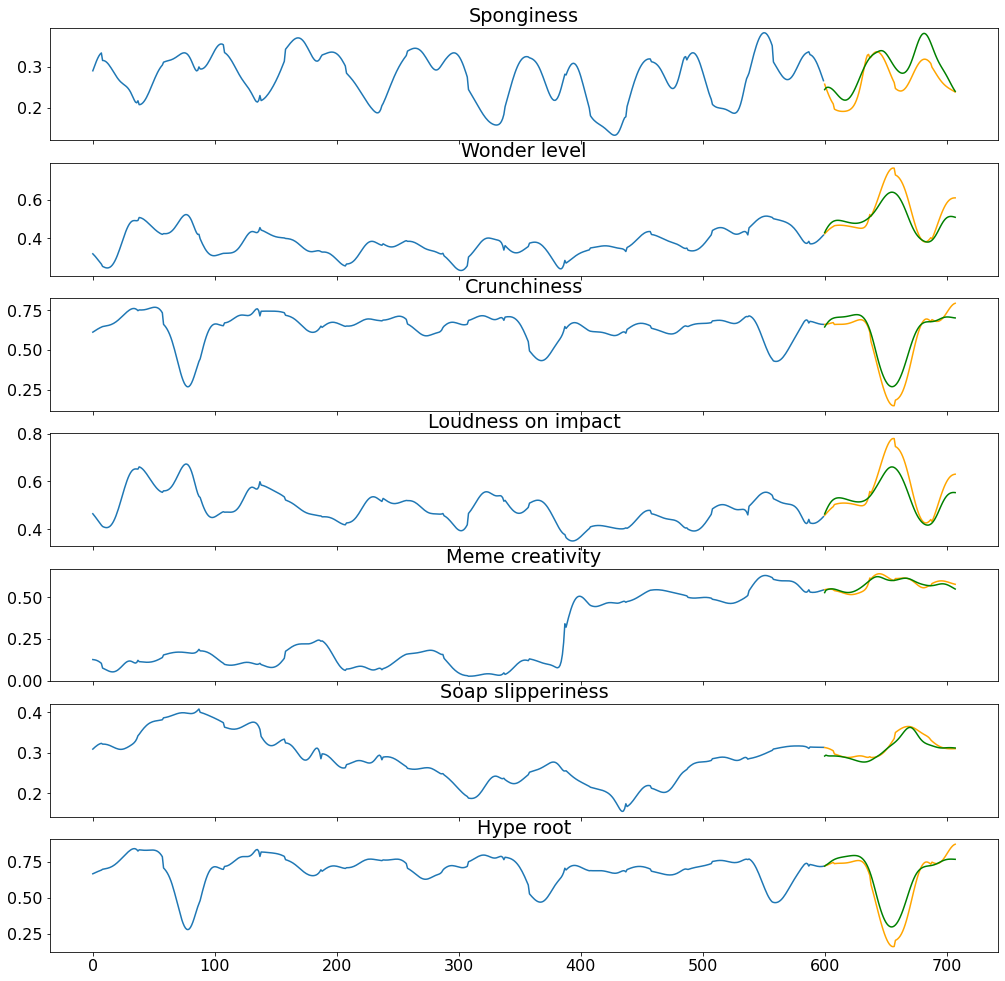

In [20]:
inspect_multivariate_prediction(x, y, predictions, dataset.columns, telescope)

In [21]:
maes = []
for i in range(predictions.shape[1]):
    ft_maes = []
    for j in range(predictions.shape[2]):
        ft_maes.append(np.mean(np.abs(y[:,i,j]-predictions[:,i,j]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [22]:
reg_telescope = 864
X_test_reg, y_test_reg  = chunk(normalized_ds, window, reg_telescope, stride)
X_test_reg = X_test_reg[-10:]
y_test_reg = y_test_reg[-10:]
X_test_reg.shape, y_test_reg.shape

((10, 600, 7), (10, 864, 7))

In [23]:
# Autoregressive Forecasting
reg_predictions = np.array([])
X_temp = X_test_reg
for reg in range(0,reg_telescope,telescope):
    pred_temp = model.predict(X_temp)
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,telescope:,:],pred_temp), axis=1)

In [24]:
mean_squared_error = tfk.metrics.mse(y_test_reg.flatten(),reg_predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test_reg.flatten(),reg_predictions.flatten())
mean_squared_error, mean_absolute_error

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0060698353>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.053081032>)

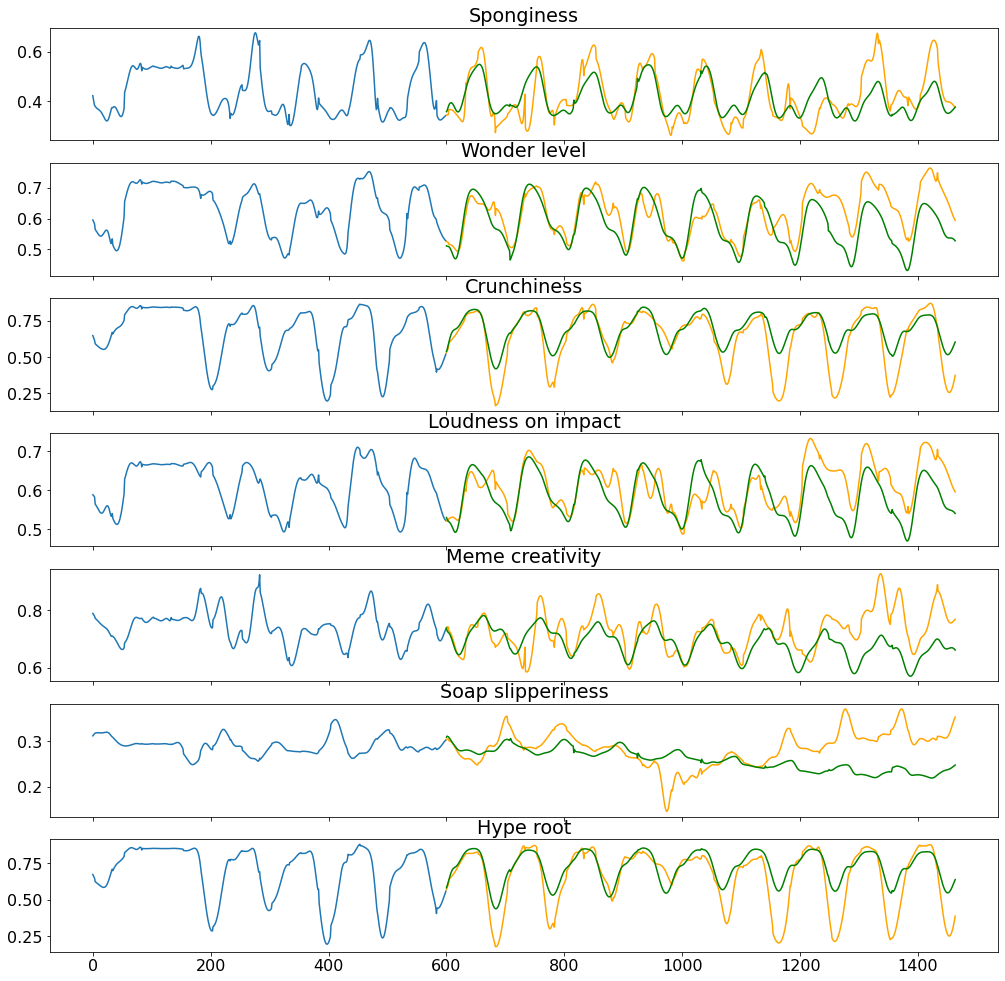

In [27]:
inspect_multivariate_prediction(X_test_reg, y_test_reg, reg_predictions, dataset.columns, reg_telescope, 8)